In [1]:
%load_ext autoreload
%autoreload 2

# Imports and Setup

In [49]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PLATFORM'] = 'GCP' # Kaggle, Colab, Paperspace, Local

import gc
import json
import pprint
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import partial
from argparse import Namespace
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from model import SimpleSupervisedModel, ArcFaceSupervisedModel, get_feature_extractor
from config import get_train_config
from data import GetDataloader
from utils import ShowBatch, id_generator, get_stratified_k_fold, setup_device, count_data_items, get_lr_callback, model_ckpt_callback
from callbacks import GetCallbacks

pp = pprint.PrettyPrinter(indent=1)

In [18]:
# Setup Device for training
strategy = setup_device()
print("REPLICAS: ", strategy.num_replicas_in_sync)

#### GPU Available ####
REPLICAS:  1


In [19]:
# Setup W&B Login
try:
    import wandb
    wandb.login()
except:
    !pip install -qqq wandb
    import wandb
    wandb.login()
else:
    from wandb.keras import WandbCallback

wandb: Currently logged in as: ayut (use `wandb login --relogin` to force relogin)


In [20]:
# Setup Platform
platform = os.getenv('PLATFORM', None)
print('Where are we working? - ', platform)

Where are we working? -  GCP


In [43]:
# Setup configs
args = get_train_config()

# Setup experiment id for W&B
random_id = id_generator(size=8)
args.exp_id = random_id
print('Experiment ID: ', args.exp_id)

# Add strategy to args
args.strategy = strategy

Experiment ID:  NNBTHZ9T


# Dataset

In [44]:
df = pd.read_csv('../cleaned_train_5_fold_individual_ids.csv')

with open('../label2ids_individual_ids.json') as json_file:
    label2ids = json.load(json_file)
    
args.num_labels = len(label2ids)
args.labels = label2ids

In [23]:
GCS_PATH = 'gs://kds-5998360efc5fefbd84f6f7ce20d9040a838bf5e72a85d1e34c10b2a4'

In [24]:
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))
print(GCS_PATH)
print(len(train_files), len(test_files), count_data_items(train_files), count_data_items(test_files))

gs://kds-5998360efc5fefbd84f6f7ce20d9040a838bf5e72a85d1e34c10b2a4
10 10 51033 27956


# DataLoader

In [72]:
AUTO = tf.data.AUTOTUNE

def argface_format(image, label):
    return {'inp1': image, 'inp2': label}, label

def data_augment(image, label):
    return image, label

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [args.image_height, args.image_width])
    image = tf.cast(image, tf.float32) / 255.0

    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string), # Name of image
        "image": tf.io.FixedLenFeature([], tf.string), # Image tensors
        "target": tf.io.FixedLenFeature([], tf.int64), # Individual ID
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image_name = example['image_name']
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    
    return image_name, image, label


def load_dataset(filenames, ordered = False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

In [73]:
def get_dataloader(filenames, 
                   type='train', # valid, eval, test
                   get_targets=True, 
                   get_names=False):
    
    if type=='train':
        order = False
    else:
        order = True
        
    dataloader = load_dataset(filenames, ordered=order)

    if type=='train':
        dataloader = dataloader.shuffle(args.batch_size*100)
        dataloader = dataloader.map(lambda image_name, image, label: (image, label))
        dataloader = dataloader.map(data_augment, num_parallel_calls=AUTO)
        dataloader = dataloader.map(argface_format, num_parallel_calls=AUTO)
        dataloader = dataloader.repeat()
    elif type=='valid':
        dataloader = dataloader.map(lambda image_name, image, label: (image, label))
        dataloader = dataloader.map(argface_format, num_parallel_calls=AUTO)
    elif type=='eval':
        dataloader = dataloader.map(lambda image_name, image, label: (image, label))
        if not get_targets:
            dataloader = dataloader.map(lambda image, label: image)
    elif type=='test':
        dataloader = dataloader.map(lambda image_name, image, label: (image_name, image))
        if not get_names:
            dataloader = dataloader.map(lambda image_name, image: image)

    dataloader = dataloader.batch(args.batch_size)
    dataloader = dataloader.prefetch(AUTO)

    return dataloader

In [62]:
trainloader = get_dataloader(train_files[0],
                             type='train', # valid, eval, test
                             get_targets=True, 
                             get_names=True)

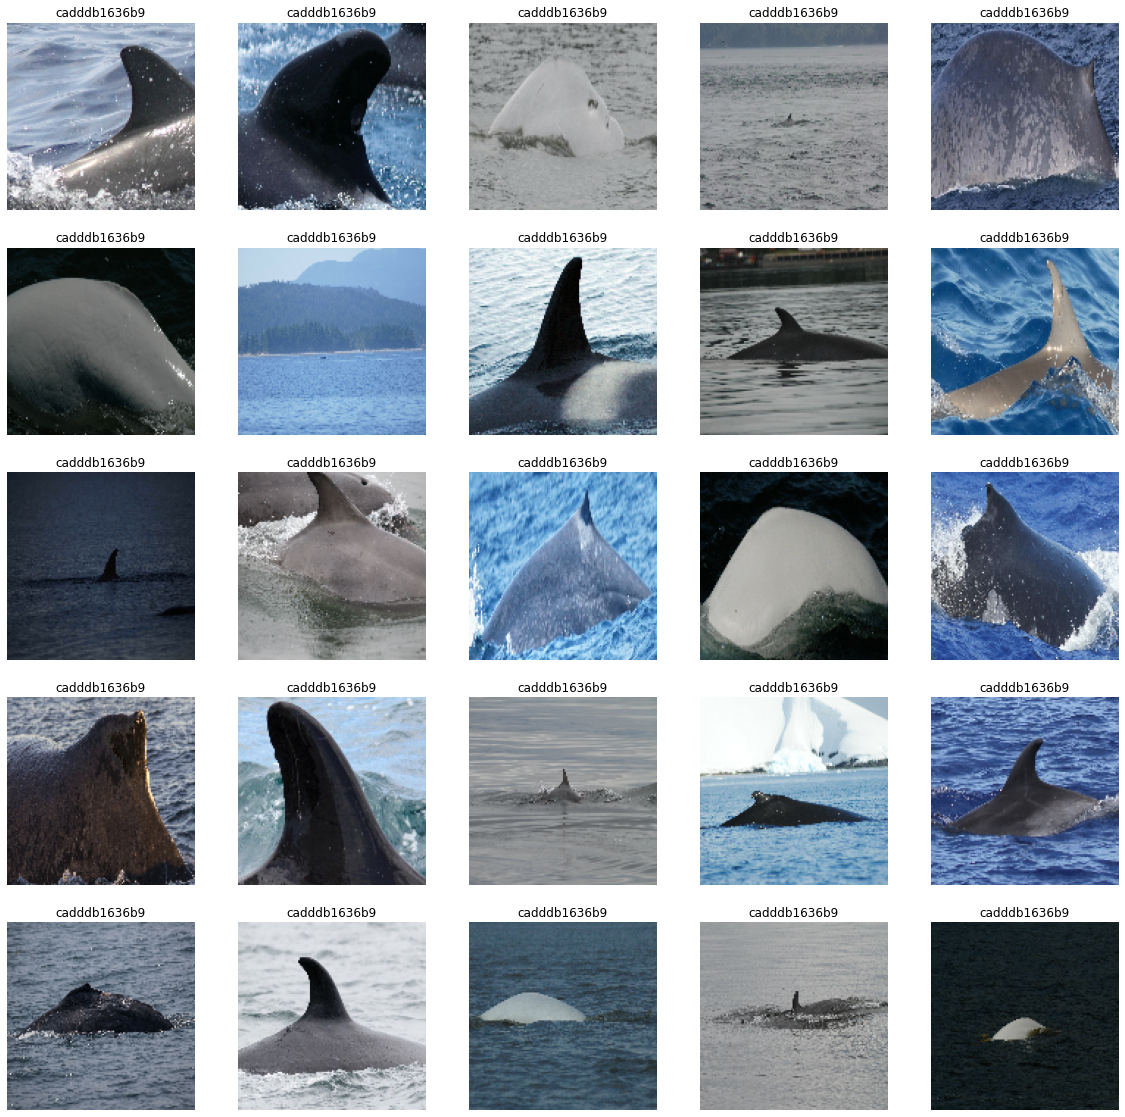

In [63]:
sample_imgs, sample_labels = next(iter(trainloader))
show_batch = ShowBatch(args)
show_batch.show_batch(sample_imgs['inp1'], sample_labels)

# Model

In [64]:
tf.keras.backend.clear_session()
model_builder = ArcFaceSupervisedModel(args)
model, embed_model = model_builder.build_model()

In [65]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b1 (Functional)    (None, None, None, 1 6575232     inp1[0][0]                       
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnet-b1[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1280)         0           global_average_pooling2d[0][0]   
______________________________________________________________________________________________

In [66]:
embed_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp1 (InputLayer)            [(None, 128, 128, 3)]     0         
_________________________________________________________________
efficientnet-b1 (Functional) (None, None, None, 1280)  6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
Total params: 7,231,104
Trainable params: 7,169,056
Non-trainable params: 62,048
_________________________________________________________________


# Callbacks

In [67]:
lr_callback = get_lr_callback(args)

In [68]:
model_ckpt = model_ckpt_callback(args, 0)

# Train

In [75]:
args.epochs = 2
for fold in range(args.num_folds):
    print(f'#### Image Size {(args.image_height, args.image_width)} with EfficientNet {args.effnet_num} and batch_size {args.batch_size} for fold {fold}')

    # Get the dataset
    TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%args.num_folds!=fold]
    VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%args.num_folds==fold]
    # Get the dataloader
    train_dataset = get_dataloader(TRAINING_FILENAMES, type='train')
    val_dataset = get_dataloader(VALIDATION_FILENAMES, type='valid')
    STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // args.batch_size
    # Get the model
    tf.keras.backend.clear_session()
    model_builder = ArcFaceSupervisedModel(args)
    model, embed_model = model_builder.build_model()
    # Get callbacks
    lr_callback = get_lr_callback(args)
    model_ckpt = model_ckpt_callback(args, fold)
    # Initialize W&B run
    run = wandb.init(project='happywhale',
                     config=vars(args),
                     group=f'effnetb1-{args.exp_id}',
                     job_type='train-gpu',
                     name=f'{args.exp_id}_{fold}_train')
    # Train
    _ = model.fit(train_dataset,
                  validation_data=val_dataset,
                  steps_per_epoch=STEPS_PER_EPOCH,
                  epochs=args.epochs,
                  callbacks=[lr_callback,
                             WandbCallback(save_model=False),
                             model_ckpt])
    # End the W&B run
    wandb.finish()
    break